# Scan parameters

In [2]:
from copy import deepcopy
from functools import partial
import os
import sys

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.style.use('seaborn-v0_8')
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import pandas as pd
import jax

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.1"
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'cpu')

import bioreaction
from bioreaction.model.data_containers import Impulse
from bioreaction.simulation.basic_sim import basic_de_sim, convert_model, BasicSimParams, BasicSimState
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.med_sim import get_int_med_model, basic_de, MedSimParams, MedSimInternalState


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

from tests.shared import five_circuits, CONFIG
from src.utils.misc.units import per_mol_to_per_molecule
from src.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from src.utils.results.analytics.timeseries import generate_analytics
from src.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols
from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info

config = deepcopy(CONFIG)

A single model:

In [2]:
num_species = 3
input_species_idx = 0
output_species_idx = 1

Keq = np.array(
    [[1, 2, 1],
     [2, 1, 0.5],
     [1, 0.5, 2]]
)
# From src/utils/common/configs/RNA_circuit/molecular_params.json
a=np.ones(3) * 0.08333
d=np.ones(3) * 0.0008333
ka=np.ones_like(Keq) * per_mol_to_per_molecule(1000000)
kd=ka/Keq

med_model = bioreaction.templates.generate_rnabinding_medsim(
    num_species=num_species,
    a=a, d=d, ka=ka,
    kd=ka/Keq,
    impulse_idx=0
)

s0 = np.concatenate([[1, 1, 1], np.zeros(len(med_model.species[num_species:]))])

# impulse = Impulse(target=med_model.species[:num_species][input_species_idx], delta_target=20, time=100.0, impulse_width=0.0)
med_model.impulses = []
poiss_simmed = jnp.zeros(len(med_model.reactions))
brown_simmed = jnp.zeros(len(med_model.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 1000.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
int_med_model = get_int_med_model(med_model)
int_med_state = MedSimInternalState(concentrations=s0, other_factors=jnp.zeros(len(med_model.other_factors)))
med_model.species



[Species: RNA 0,
 Species: RNA 1,
 Species: RNA 2,
 Species: RNA 0-0,
 Species: RNA 0-1,
 Species: RNA 0-2,
 Species: RNA 1-1,
 Species: RNA 1-2,
 Species: RNA 2-2]

In [3]:

def update_model_rates(model, a, d, ka, kd):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            model.reactions[i].forward_rate = a[model.species.index(
                r.output[0])]
            model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            model.reactions[i].forward_rate = d[model.species.index(
                r.input[0])]
            model.reactions[i].reverse_rate = 0
        else:
            model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                 model.species.index(r.input[1])]
            model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                 model.species.index(r.input[1])]
    return model


def update_model_kd(model, kd):
    for i, r in enumerate(model.reactions):
        if r.input and r.output:
            model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                 model.species.index(r.input[1])]
    return model


med_model = update_model_rates(med_model, a, d, ka, kd)


In [4]:
result_1 = basic_de(int_med_state, int_med_model, int_med_params)

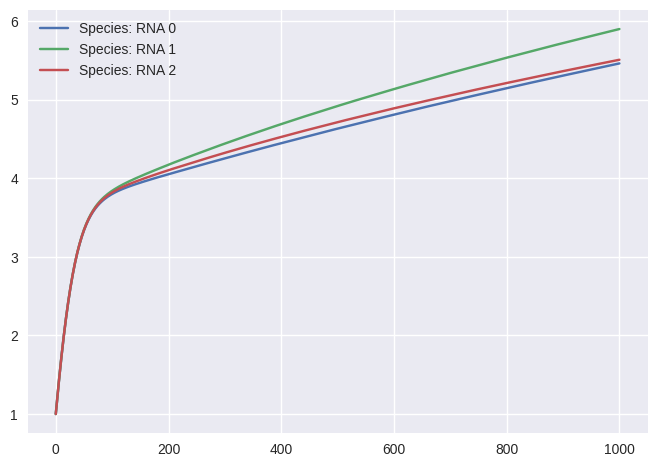

In [5]:

plt.plot(result_1.ts, np.array(result_1.ys.concentrations)[:, :num_species], label=[str(s) for s in med_model.species[:num_species]])
plt.legend()

### Checking that new med sim is the same as bioreactions sim
Comparison looks good

In [6]:
model = construct_model_fromnames([str(i) for i in range(num_species)])
model.species = model.species[-num_species:] + model.species[:-num_species]
model = update_model_rates(model, a, d, ka, kd)
sim_model = convert_model(model)
starting_state = BasicSimState(concentrations=s0)
params = BasicSimParams(delta_t=0.01, total_time=1000.0)

state = basic_de_sim(starting_state=starting_state, model=sim_model, params=params)
results_species = np.concatenate([np.expand_dims(starting_state.concentrations, axis=0), state[1]])
t = np.arange(params.total_time / params.delta_t) * params.delta_t


In [7]:
result_dfx = bioreaction_sim_dfx_expanded(y0=s0, t0=0, t1=params.total_time, dt0=params.delta_t,
                                          inputs=sim_model.inputs, outputs=sim_model.outputs,
                                          forward_rates=sim_model.forward_rates, reverse_rates=sim_model.reverse_rates,
                                          signal=lambda x: x, signal_onehot=np.zeros(len(model.species)))
result_dfx_y = result_dfx.ys[result_dfx.ts < np.inf]
result_dfx_t = result_dfx.ts[result_dfx.ts < np.inf]

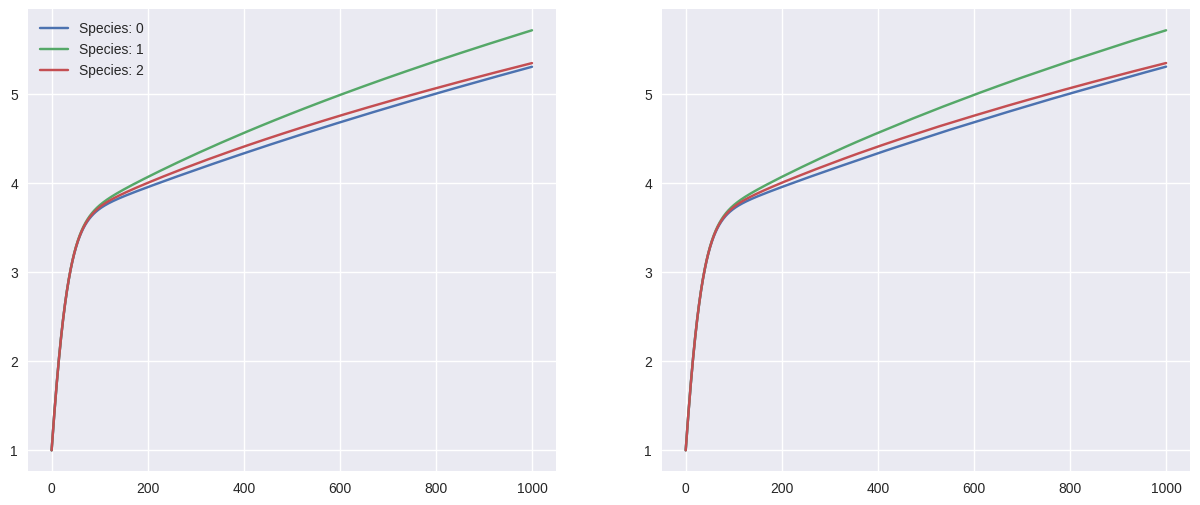

In [8]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1,2,1)
plt.plot(t, results_species[:, :num_species])
plt.legend(model.species[:num_species])

ax = plt.subplot(1,2,2)
# till = int(5 / params.delta_t)
plt.plot(result_dfx_t, result_dfx_y[:, :num_species])


While basic_de is the fastest, it's probably not as fast when vmap comes in.

In [9]:
def to_vmap_dfx(forward_rates, reverse_rates):
    return bioreaction_sim_dfx_expanded(y0=s0, t0=0, t1=params.total_time, dt0=params.delta_t,
                                        inputs=sim_model.inputs, outputs=sim_model.outputs,
                                        forward_rates=forward_rates, reverse_rates=reverse_rates,
                                        signal=lambda x: x, signal_onehot=np.zeros(len(model.species)))


def to_vmap_basic(sim_model):
    return basic_de_sim(starting_state=starting_state, model=sim_model, params=params)


def to_vmap_basic_med(int_med_model):
    return basic_de(int_med_state, int_med_model, int_med_params)


vmap1 = jax.jit(jax.vmap(to_vmap_dfx))
vmap2 = jax.jit(jax.vmap(to_vmap_basic))
vmap3 = jax.jit(jax.vmap(to_vmap_basic_med))


In [10]:

frs = np.array([sim_model.forward_rates + i for i in range(3)])
revs = np.array([sim_model.reverse_rates + i for i in range(3)])
res1 = vmap1(frs, revs)

In [11]:
tf = np.argmax(res1.ts >= np.inf)
tf

DeviceArray(99935, dtype=int32)

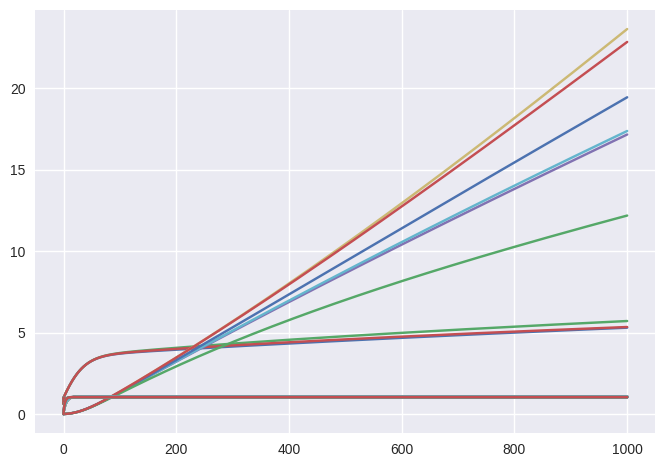

In [12]:
res1.ys[res1.ts < np.inf]
res1.ts[res1.ts < np.inf]
for p in range(3):
    plt.plot(res1.ts[p, :tf], res1.ys[p, :tf, :])
# plt.legend(model.species[:num_species])

## Scan

In [13]:

from src.utils.misc.numerical import make_symmetrical_matrix_from_sequence, triangular_sequence

interaction_strengths = np.concatenate(
    (np.arange(0.01, 1, 0.2), np.arange(1, 5, 0.5)))
size_interaction_array = np.size(interaction_strengths)
num_unique_interactions = np.math.factorial(num_species)

# Create matrices
def define_matrices(num_species, size_interaction_array, num_unique_interactions, analytic_types):
    matrix_dimensions = tuple(
        [num_species] + [size_interaction_array]*num_unique_interactions)
    matrix_size = num_species * \
        np.power(size_interaction_array, num_unique_interactions)
    assert matrix_size == np.prod(list(
        matrix_dimensions)), 'Something is off about the intended size of the matrix'

    all_analytic_matrices = []
    for _analytic in analytic_types:
        all_analytic_matrices.append(np.zeros(
            matrix_dimensions, dtype=np.float32))
    return all_analytic_matrices


# Set loop vars
analytic_types = ['precision']
all_analytic_matrices = define_matrices(
    num_species, size_interaction_array, num_unique_interactions, analytic_types)

# total_iterations = np.power(
#     size_interaction_array, num_unique_interactions)
total_iterations = np.power(size_interaction_array, num_unique_interactions)
total_processes = 1
sub_process = 0
num_iterations = int(total_iterations / total_processes)
starting_iteration = int(num_iterations * sub_process)
end_iteration = int(num_iterations * (sub_process + 1))


In [14]:
Keqs = np.zeros((num_iterations, num_species, num_species))
for i in range(num_iterations):
    interaction_strength_choices = np.floor(
        np.mod(i / np.power(size_interaction_array, np.arange(num_unique_interactions)), size_interaction_array)).astype(int)
    flat_triangle = interaction_strengths[list(
        interaction_strength_choices)]
    Keqs[i] = make_symmetrical_matrix_from_sequence(
        flat_triangle, num_species)

In [15]:
def make_models(model, new_kds):
    models = [deepcopy(model) for i in new_kds]
    models = [update_model_kd(model, new_kd) for model, new_kd in zip(model, new_kds)]
    return models

In [16]:
def make_reverse_rates(med_model, int_med_model, interaction_matrices):
    index_translation = []
    for i, r in enumerate(med_model.reactions):
        if r.output and r.input:
            index_translation.append([i, med_model.species.index(r.input[0]),
                                      med_model.species.index(r.input[1])])
    reverse_rates = np.repeat(
        np.expand_dims(int_med_model.reactions.reverse_rates, axis=0),
        interaction_matrices.shape[0], axis=0
    )
    for i, k, j in index_translation:
        reverse_rates[:, i] = interaction_matrices[:, k, j]
    return reverse_rates

kds = ka / Keqs
b_reverse_rates = make_reverse_rates(med_model, int_med_model, kds)


In [111]:

int_med_params = MedSimParams(delta_t= 0.1, t_start=0.0, t_end = 250000.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
int_med_model = get_int_med_model(med_model)
int_med_state = MedSimInternalState(concentrations=s0, other_factors=jnp.zeros(len(med_model.other_factors)))

sim_dfx = partial(bioreaction_sim_dfx_expanded,
                  y0=s0, t0=int_med_params.t_start, t1=int_med_params.t_end, dt0=int_med_params.delta_t,
                  inputs=int_med_model.reactions.inputs, outputs=int_med_model.reactions.outputs,
                  forward_rates=int_med_model.reactions.forward_rates,
                  signal=lambda x: x, signal_onehot=np.zeros(len(med_model.species))
                  )

def to_vmap_dfx(reverse_rates):
    return sim_dfx(reverse_rates=reverse_rates)

vmap_dfx = jax.jit(jax.vmap(to_vmap_dfx))
res_dfx = vmap_dfx(b_reverse_rates[:20])


In [ ]:
tf = np.argmax(res_dfx.ts[0] >= np.inf)
y_dfx = res_dfx.ys[:, :tf, :]
t_dfx = res_dfx.ts[0, :tf]


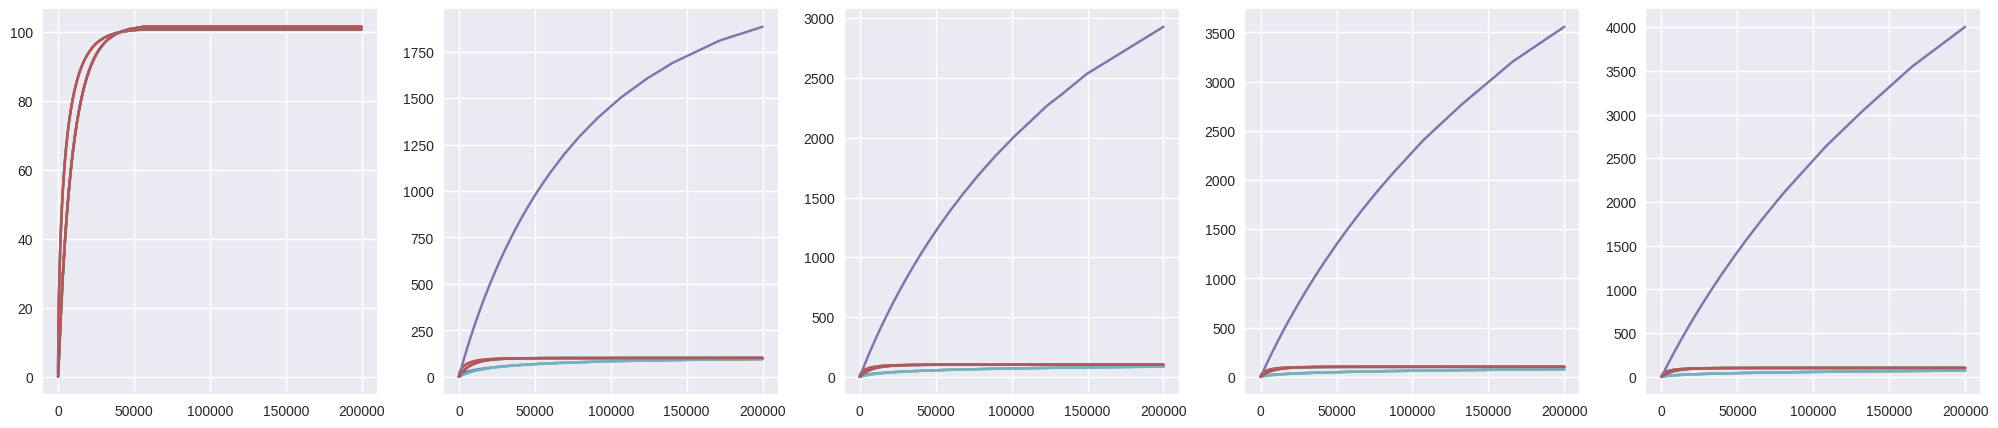

In [ ]:
fig = plt.figure(figsize=(25, 25))
for i in range(20):
    ax = plt.subplot(5,5,i+1)
    plt.plot(res_dfx.ts[0, :tf], res_dfx.ys[i, :tf, :])
# plt.legend(model.species[:num_species])

In [109]:
signal_onehot = np.array([i == input_species_idx for i in range(len(med_model.species))] * 1)
analytics = generate_analytics(y_dfx, t_dfx, labels=model.species, 
                               ref_circuit_data=y_dfx[0], signal_onehot=None, #signal_onehot,
                               signal_target=None)
analytics_types = get_true_names_analytics(analytics)
analytics_types


['initial_steady_states',
 'max_amount',
 'min_amount',
 'RMSE',
 'steady_states',
 'fold_change',
 'overshoot',
 'initial_steady_states_diff_to_base_circuit',
 'max_amount_diff_to_base_circuit',
 'min_amount_diff_to_base_circuit',
 'RMSE_diff_to_base_circuit',
 'steady_states_diff_to_base_circuit',
 'fold_change_diff_to_base_circuit',
 'overshoot_diff_to_base_circuit',
 'initial_steady_states_ratio_from_mutation_to_base',
 'max_amount_ratio_from_mutation_to_base',
 'min_amount_ratio_from_mutation_to_base',
 'RMSE_ratio_from_mutation_to_base',
 'steady_states_ratio_from_mutation_to_base',
 'fold_change_ratio_from_mutation_to_base',
 'overshoot_ratio_from_mutation_to_base']

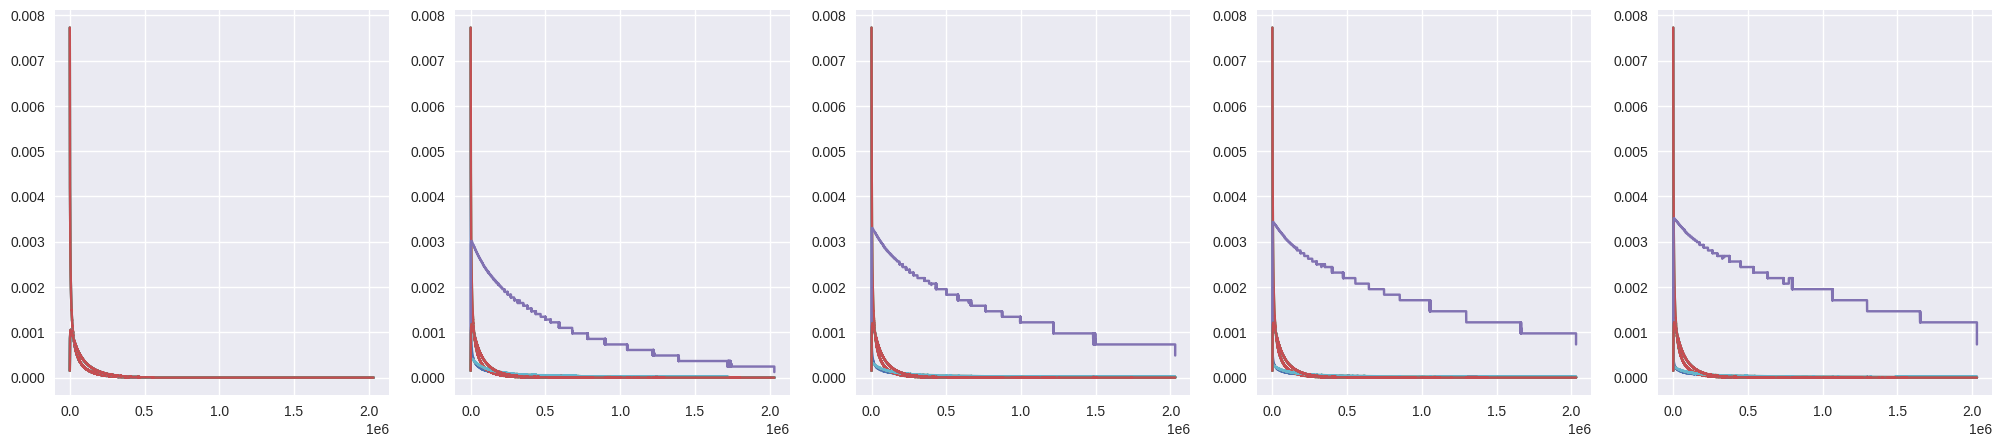

In [110]:
fig = plt.figure(figsize=(25, 5))
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    plt.plot(analytics['first_derivative'][i, :, :])
# plt.legend(model.species[:num_species])

In [44]:
analytics_df = pd.DataFrame({k: analytics[k] for k in analytics_types}, index=med_model.species)
analytics_df

ValueError: Data must be 1-dimensional